**18 Apr, Touchpoint**

1. Kick-off on April 12th with Debbie, in which some doubts were clarified and the **concept and code for development were introduced**. 

2. The **frequency analysis was implemented**, so that it is possible to reproduce the analysis between spatial and temporal domains, according to the [FFL paper](https://arxiv.org/pdf/2012.12821.pdf). 

3. It was **not yet possible to reproduce the results for the [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)** using either CPU and GPU. My main hypothesis is related to the data, since I didn't have access to the one used for training and had to download it.

4. Given the issue with CelebA, I chose to do at first a **POC with FashionMNIST**. Using the same CelebA Autoencoder, I trained the model using 3 different metrics: MSE, FFL and AWL. For 5 epochs, **preliminary results indicate that AWL was able to better reconstruct images**. 

**Next steps**

1. **Identify the problem with CelebA** so that it is possible to train the model on this dataset. In the future, reproduce with CelebAHQ

2. **Access to a more robust machine**, so that it is possible to accelerate the training. 

3. Isolate the FFL metric for training, without the MSE. 

4. Try on Variational AE

# Setup

In [1]:
# Mount drive
from google.colab import drive
drive.mount("/content/gdrive")

# Set up the files
%cp -av /content/gdrive/MyDrive/utils /content/utils

# Set up the dataset
!mkdir data
!mkdir data/CelebA
!unzip /content/gdrive/MyDrive/CelebA/img_align_celeba.zip -d /content/data/CelebA/

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/CelebA/img_align_celeba/197600.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197601.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197602.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197603.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197604.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197605.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197606.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197607.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197608.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197609.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197610.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197611.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197612.jpg  
 extracting: /content/data/CelebA/img_align_celeba/197613.jpg  
 extracting: /content/data/CelebA/img_align_celeba/19

In [2]:
# Set up the environment
!pip install -r utils/requirements.txt --quiet
!pip install -r utils/requirements-optional.txt --quiet
!pip install livelossplot --quiet
!pip install torch-summary>=1.4.5 --quiet
!pip install progressbar2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.9/867.9 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.9/721.9 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:

# Imports

In [3]:
import copy
import os
import random

from utils.awloss import AWLoss
from utils.freqloss import FocalFrequencyLoss as FFLoss

%load_ext autoreload
import numpy as np
import torch
import torch.nn as nn

from livelossplot import PlotLosses
from progressbar import ProgressBar
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Grayscale
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

%autoreload 2
import sys
sys.path.append('../') 
from utils.networks import *
from utils.utils import *
from utils.landscape import *
from utils.datasets import *
from utils.train_utils import *

import json
import pathlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Hyperparameters

In [4]:
# Note: The utils functions below were taken from the from notebooks provided in the lectures.
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

set_seed(42)
device = set_device("cuda")
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

Cuda installed! Running on GPU 0 Tesla T4!


In [5]:
# Set training static parameters and hyperparameters
nepochs = 5
latent_size = 128                            
learning_rate = 1e-3
batch_size = 512                                        
valid_ratio = 0.2
logf = int(nepochs//5) + 1
sampling = .2

# Dataset

Total: 202599
    Training images: 162080 
    Validation Images: 40519


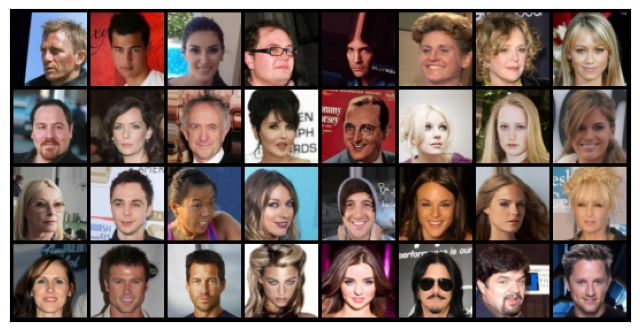



torch.Size([32, 3, 64, 64]) 0.0 1.0


In [6]:
# Datasets and Dataloaders
img_dim = 64
dataset = ImageFolder(root="./data/CelebA/",
                      transform=Compose([
                          Resize(img_dim),
                          CenterCrop(img_dim),
                          ToTensor()
                       ]))

# Train an Validation split
idxs = np.arange(0, len(dataset), 1)
np.random.shuffle(idxs)
train_idxs, valid_idxs = (idxs[:-int(len(dataset) * valid_ratio)],
                         idxs[-int(len(dataset) * valid_ratio):])

# train_idxs, valid_idxs = (idxs[:int(len(dataset) * (1 - valid_ratio) * 0.05)],
#                          idxs[-int(len(dataset) * valid_ratio * 0.05):])

trainds, validds = (Subset(dataset, train_idxs), 
                    Subset(dataset, valid_idxs))
print(f"Total: {len(trainds) + len(validds)}")
print("    Training images: {} \n    Validation Images: {}".format(len(trainds), len(validds)))

# Dataloaders
train_loader = DataLoader(trainds, batch_size=batch_size, 
                          shuffle=True, 
                        #   num_workers=4
                          num_workers=2)
valid_loader = DataLoader(validds, batch_size=batch_size, 
                          shuffle=False, 
                        #   num_workers=4
                          num_workers=2)

# Visualise batch
sample_batch = next(iter(train_loader))[0][:32]
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(make_grid(sample_batch, pad_value=0, padding=3).numpy(), (1,2,0)))
plt.xticks([]); plt.yticks([])
plt.show()

print("\n")
print(sample_batch.shape, sample_batch.min().item(), sample_batch.max().item())

# Model (Utils)

In [7]:
class Convolution(nn.Module):
    """Base class for convolution operations"""
    def __init__(self, input, output,
                 kernel=3, padding=1, stride=1,
                 activation="Mish"):
        """
        Parameters
        ----------
        input : int
            Input channels

        output : int
            Output channels

        kernel : int or tuple
            Kernel size

        padding : int
            Padding size

        stride : int or tuple
            Stride size

        activation : str
            Activation function. Available is "LeakyReLU", "ReLU",
            "Tanh", "Mish" and "Sigmoid"
        """
        super(Convolution, self).__init__()

        # Define the activation layer
        if activation == "LeakyReLU":
            self.activation = nn.LeakyReLU(0.2)
        elif activation == "ReLU":
            self.activation = nn.ReLU()
        elif activation == "Tanh":
            self.activation = nn.Tanh()
        elif activation == "Mish":
             self.activation = nn.Mish()   
        elif activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Activation function not implemented.")

        # Define the convolutional layer
        self.convolution = nn.Sequential(
            nn.Conv2d(input, output,
                      kernel_size=kernel,
                      padding=padding,
                      stride=stride),
            nn.BatchNorm2d(output),
            self.activation,
        )

    def forward(self, x):
        """Apply the forward operation.

        Parameters
        ---------
        x : torch.tensor
            image
        """
        return self.convolution(x)


class Encoder(nn.Module):
    """Convolutional Autoencoder"""
    def __init__(self, 
                 channels, features,
                 latent_dimension, 
                 img_dim):
        """
        Parameters
        ----------
        channels : int
            Number of channels of the images

        features : int
            Number of input features in the discriminator
            
        latent_dimension : int
            Number of dimensions of the latent space 

        img_dim : 
            Number of pixels in one dimension of the image 
        """
        super(Encoder, self).__init__()

        # Define the encoder 
        self.encoder = nn.Sequential(
            # output: bs,   features, img_dim, img_dim
            Convolution(input=channels, output=features),

            # output: bs,   features, img_dim/2, img_dim/2
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            # output: bs, 2*features, img_dim/2, img_dim/2
            Convolution(input=features, output=features * 2),

            # output: bs, 2*features, img_dim/4, img_dim/4
            torch.nn.MaxPool2d(kernel_size=(2, 2)),

            # output: bs, 4*features, img_dim/4, img_dim/4
            Convolution(input=features * 2, output=features * 4), 

            # output: bs, 4*features*(img_dim/4)**2
            nn.Flatten(start_dim=1), 

            # output: latent_dimension
            nn.Linear(int(4 * features * img_dim / 4 * img_dim / 4),
                      latent_dimension),
        )
        
        # Initialize the weights following N(0, 0.02)
        self.init_parameters()

    def init_parameters(self, mean=0, std=0.02):
        """Force initialization of parameters according
           to Radford et. al (2015). Adapted from RNN lecture 
           notebook
           
        Parameters
        ----------
        mean : float
            Mean for parameters initialization

        std : float
            Standard deviation forparameters initialization
        """
        for w in self.parameters():
            w.data.normal_(mean, std)

    def forward(self, x):
        """Apply the forward operation on the Encoder.

        Parameters
        ---------
        x : torch.tensor
            FashionMNIST image
        """
        # Perform the encoding
        z = self.encoder(x)
        return z


class Decoder(nn.Module):
    """Convolutional Decoder"""
    def __init__(self, 
                 channels, features,
                 latent_dimension,
                 img_dim):
        """
        Parameters
        ----------
        channels : int
            Number of channels of the images
        
        features : int
            Number of input features in the discriminator
        
        latent_dimension : int
            Size of the input tensor in the generator

        img_dim : 
            Number of pixels in one dimension of the image 
        """
        super(Decoder, self).__init__()

        # Define the decoder 
        self.decoder = nn.Sequential(
            # output: bs, 4*features*(img_dim/4)**2
            nn.Linear(latent_dimension, int(4 * features * img_dim / 4 * img_dim / 4)),

            # output: bs, 4*features, img_dim/4, img_dim/4
            nn.Unflatten(dim=1, unflattened_size=(4 * features, int(img_dim / 4), int(img_dim / 4))),

            # output: bs, 2*features, img_dim/4, img_dim/4
            Convolution(input=(4 * features), output=features * 2),

            # output: bs, 2*features, img_dim/2, img_dim/2
            torch.nn.Upsample(scale_factor=2),

            # output: bs,   features, img_dim/2, img_dim/2
            Convolution(input=features * 2, output=features * 1),

            # output: bs,   features,   img_dim,  img_dim
            torch.nn.Upsample(scale_factor=2),

            # output: bs,   features,   img_dim,  img_dim
            torch.nn.Conv2d(features, channels, 3, 1, 1),

            torch.nn.Sigmoid()
        )

        # Initialize the weights following N(0, 0.002)
        self.init_parameters()

    def init_parameters(self, mean=0, std=0.02):
        """Force initialization of parameters according
           to Radford et. al (2015). Adapted from RNN lecture 
           notebook
           
        Parameters
        ----------
        mean : float
            Mean for parameters initialization

        std : float
            Standard deviation forparameters initialization
        """
        for w in self.parameters():
            w.data.normal_(mean, std)

    def forward(self, z):
        """Apply the forward operation on the Decoder.

        Parameters
        ---------
        x : torch.tensor
            FashionMNIST image
        """
        # Decode
        y = self.decoder(z)
        return y

class CAE(nn.Module):
    """Convolutional Autoencoder"""
    def __init__(self, device, channels, features,
                 latent_dimension, img_dim):
        """
        Parameters
        ----------
        device : str
            Device for the calculations

        channels : int
            Number of channels of the images
        
        features : int
            Number of input features in the discriminator
            
        latent_dimension : int
            Size of the input tensor in the generator

        img_dim : 
            Number of pixels in one dimension of the image 
        
        """
        super(CAE, self).__init__()
        self.device = device
        self.encoder = Encoder(channels=channels, features=features,
                               latent_dimension=latent_dimension,
                               img_dim=img_dim)
        self.decoder = Decoder(channels=channels, features=features,
                               latent_dimension=latent_dimension,
                               img_dim=img_dim)
        self.distribution = torch.distributions.Normal(0, 1)

    def forward(self, x):
        '''Apply the forward operation on the CCVAE.

        Parameters
        ---------
        x : torch.tensor
            FashionMNIST image
        
        '''
        z = self.encoder(x)                  # Run the image through the Encoder
        y = self.decoder(z)                  # Return the output of the decoder (the predicted image)
        return y


def model_instance(device, channels, 
                   features, latent_dimension,
                   img_dim):
    """Create an instance of the model.
    
    Parameters
    ----------
    device : str
        Device for the calculations

    channels : int
        Number of channels of the images
    
    features : int
        Number of input features in the discriminator
        
    latent_dimension : int
        Size of the input tensor in the generator

    img_dim : 
        Number of pixels in one dimension of the image 
    
    """
    # Instantiate the model
    model = CAE(device=device, channels=channels,
                features=features,
                latent_dimension=latent_dimension,
                img_dim=img_dim).to(device).to(device)
    
    # Parallelise the model
    # model = nn.DataParallel(model, device_ids=[0, 1])
    model = nn.DataParallel(model)

    return model

# Model

In [8]:
# Hyperparameters
channels = 3                                        # Number of channels in the images
features = 16                                       # Number of input features in the encoder
latent_dimension = 128                              # Number of dimensions of the latent space  

# Model Summary
_ = summary(model=model_instance(device=device, channels=channels,
                                 features=features,
                                 latent_dimension=latent_dimension,
                                 img_dim=img_dim),
            input_data=sample_batch[0].shape,
            verbose=1, depth=4, 
            col_names=["input_size", 
                       "output_size", 
                       "num_params"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
├─CAE: 1-1                                    [-1, 3, 64, 64]           [-1, 3, 64, 64]           --
|    └─Encoder: 2-1                           [-1, 3, 64, 64]           [-1, 128]                 --
|    |    └─Sequential: 3-1                   [-1, 3, 64, 64]           [-1, 128]                 --
|    |    |    └─Convolution: 4-1             [-1, 3, 64, 64]           [-1, 16, 64, 64]          480
|    |    |    └─MaxPool2d: 4-2               [-1, 16, 64, 64]          [-1, 16, 32, 32]          --
|    |    |    └─Convolution: 4-3             [-1, 16, 32, 32]          [-1, 32, 32, 32]          4,704
|    |    |    └─MaxPool2d: 4-4               [-1, 32, 32, 32]          [-1, 32, 16, 16]          --
|    |    |    └─Convolution: 4-5             [-1, 32, 16, 16]          [-1, 64, 16, 16]          18,624
|    |    |    └─Flatten: 4-6                 [-1, 64, 16, 16]          [-1, 1

# Training (Utils)

In [9]:
# Define the training step
def train(model, data, optimiser, criterion, scheduler=None, device="cpu"):
    """Training step.

    Parameters
    ----------
    model : object
        Convolutional Autoencoder

    data : DataLoader
        Training dataset
    
    criterion : method
        Metric for evaluation

    optimiser : object
        Optimiser

    scheduler : object
        Schedulet object

    device : str
            Device for the calculations

    Returns
    -------
        Training Loss

    """
    model.train()                                                   # Set the model to training mode
    total = 0.                                                      # Initialize the total loss
    for images, label in data:                                      # Iterate over batches of images
        images = images.to(device)
        optimiser.zero_grad()                                       # Set optimiser grad to 0
        recon = model(images)                                       # Generate predicted images
        loss = criterion(recon, images)                             # Calculate the loss
        loss.backward()                                             # Back-propagate
        optimiser.step()                                            # Step the optimiser
        optimiser.zero_grad()                                       # Set optimiser grad to 0
        total += loss.item() * images.size(0) / len(data.dataset)   # Stores the total loss per batch
    
    if scheduler:                                                   # Scheduler for learning rate
        scheduler.step()

    return total

# Define the validation step
def validate(model, data, criterion, device="cpu"):
    """Validation step.

    Parameters
    ----------
    model : object
        Convolutional Autoencoder

    data : DataLoader
        Training dataset

    criterion : method
        Metric for evaluation

    device : str
            Device for the calculations

    Returns
    -------
        Validation Loss

    """
    model.eval()                                                        # Set the model to evaluation mode
    total = 0.                                                          # Initialize the total loss
    with torch.no_grad():                                               # Deactivate the gradient
        for images, label in data:                                      # Iterate over batches of images
            images = images.to(device)
            recon = model(images)                                       # Generate predicted images
            loss = criterion(recon, images)                             # Calculate the loss
            total += loss.item() * images.size(0) / len(data.dataset)   # Stores the total loss per batch
    return total


def plot(model, data, log, n=(2, 6), idxs=None):
    """Plot the training loss and a comparisson between
    original images and its reconstructions.

    Parameters
    ----------
    model : dict
        Dictionary containing a Convolutional Autoencoder model for each metric

    data : DataLoader
        Training dataset

    log : dict
        Dictionary containing the loss and epochs

    n : tuple(int, int)
        Number of images in row and columns to be plotted. The total number
        of images will be given by the multiplication of the values.

    idxs : list-like, default=None
        List of data indices to be used for visualisation. Default is
        None, which generates random sampling

    Returns
    -------
        List of data indices used for visualisation.

    """
    # Get the batch for comparison
    images, labels = next(iter(data))
    
    # Set up plot
    fig = plt.figure(figsize=(27, 16))
    outer = gridspec.GridSpec(1, 2, wspace=0.05, hspace=0,
                              width_ratios=[0.25, 0.75])

    # Loss plot
    metrics = [key.split("_")[-1] for key in log.keys()
                                if "_" in key and "training" in key]
    intermediate_loss = gridspec.GridSpecFromSubplotSpec(len(metrics), 1,
                            subplot_spec=outer[0], 
                            wspace=0.1, hspace=0.2)

    for i, metric in enumerate(metrics):
        ax = plt.Subplot(fig, intermediate_loss[i])
        ax.plot(log["epochs"], log["training_" + metric], 
                label="Training")
        ax.plot(log["epochs"], log["validation_" + metric], 
                label="Validation")
        ax.grid(alpha=.25)
        if i == len(metrics) - 1:
            ax.set_xlabel("Epochs")
        else:
            ax.get_xaxis().set_visible(False)
        ax.title.set_text(metric + " Loss")
        ax.legend()
        fig.add_subplot(ax)

    # Visualise
    intermediate = gridspec.GridSpecFromSubplotSpec(n[0] * (len(metrics) + 1), n[1],
                        subplot_spec=outer[1], 
                        wspace=0.1, hspace=0.1)
    
    if idxs is None:
        idxs = torch.randint(0, images.shape[0], (n[0] * n[1], ))

    for i, idx in enumerate(idxs):
        # Original image
        inner_real = gridspec.GridSpecFromSubplotSpec(1, 2,
                         subplot_spec=intermediate[i], 
                         wspace=0.05, hspace=0)

        # Spatial Domain
        ax = plt.Subplot(fig, inner_real[0])
        ax.imshow(np.transpose(images[idx].squeeze().numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i < n[1]:
            ax.title.set_text("[Orig.] ")
        fig.add_subplot(ax)

        # Frequency Domain
        gray_image = Grayscale()(images[idx])
        fft = torch.fft.fft2(gray_image)
        fftshifted = torch.fft.fftshift(fft)

        ax = plt.Subplot(fig, inner_real[1])
        ax.imshow(np.transpose(torch.log(1 + torch.abs(fftshifted)).numpy(),
                            (1, 2, 0)),
                cmap="gist_heat")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(ax)

        for k, metric in enumerate(model.keys()):
            # Set to evaluation
            model[metric].eval()

            # Recon Model
            inner_recon = gridspec.GridSpecFromSubplotSpec(1, 2,
                            subplot_spec=intermediate[i + (k + 1) * n[0] * n[1]],
                            wspace=0.05, hspace=0)
            
            # Spatial Domain
            recon = model[metric](images[idx].unsqueeze(0).to(device))
            ax = plt.Subplot(fig, inner_recon[0])
            ax.imshow(np.transpose(recon.cpu().detach().squeeze().numpy(), (1, 2, 0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i < n[1]:
                ax.title.set_text("[" + metric + "]")
            fig.add_subplot(ax)

            # Reconstructed Image (Frequency Domain)
            gray_image = Grayscale()(recon)
            fft = torch.fft.fft2(gray_image)
            fftshifted = torch.fft.fftshift(fft)

            ax = plt.Subplot(fig, inner_recon[1])
            ax.imshow(torch.log(1 + torch.abs(fftshifted)).squeeze().cpu().detach().numpy(), 
                      cmap="gist_heat")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            fig.add_subplot(ax)

    plt.show()
    print("\n")
    return idxs


# Set the model training function
def train_model(model, train_data, valid_data, optimiser, criterion,
                scheduler=None, device="cpu", epochs=100, 
                gradflow=False, save=False, fcmap="seismic", summary_app={},
                plot_frequency=10, plot_idxs=None):
    """Model training.

    Parameters
    ----------
    model : dict
        Dictionary containing a Convolutional Autoencoder model for each metric

    train_data : DataLoader
        Training dataset

    valid_data : DataLoader
        Validation dataset
    
    optimiser : dict
        Dictionary containing an optimiser for each metric

    criterion : dict
        Dictionary containing the metrics

    scheduler : object, default=None
        Schedulet object

    device : str
            Device for the calculations

    epochs : int, default=100
        Training epochs

    plot_frequency: int
        Frequency in which the training results will be plotted
    
     plot_idxs : list-like, default=None
        List of data indices to be used for visualisation. Default is
        None, which generates random sampling

    Returns
    -------
        Dictionary containing trained Convolutional Autoencoder models

    """
    # Set the logging
    log = {"epochs": []}
    log.update({"training_" + metric: [] for metric in model.keys()})
    log.update({"validation_" + metric: [] for metric in model.keys()})

    for epoch in tqdm(range(epochs), leave=True):
        log['epochs'].append(epoch)
        for metric in model.keys():
            # Training step
            train_loss = train(model[metric], train_data,
                            optimiser[metric], criterion[metric],
                            scheduler, device)
            log['training_' + metric].append(train_loss)

            # Validation step
            valid_loss = validate(model[metric], valid_data,
                                criterion[metric], device)
            log['validation_' + metric].append(valid_loss)

        # Visualise the training results at a certain frequency
        if epoch % plot_frequency == 0 or epoch == epochs - 1:
            plot_idxs = plot(model, valid_loader, log, idxs=plot_idxs)

    return model

In [10]:
def scale2range(x, range=[-1, 1]):
    x_n = (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)
    return x_n    

def laplacian3D(mesh):
    alpha, beta = -0.3, 1.5
    xx, yy, zz = mesh[:, :, :, 0], mesh[:, :, :, 1], mesh[:, :, :, 2]
    x = torch.sqrt(xx**2 + yy**2 + zz**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.2, 1.])
    return T

# Training

In [ ]:
# Hyperparameters
channels = 3                                        # Number of channels in the images
features = 16                                       # Number of input features in the encoder
latent_dimension = 128                              # Number of dimensions of the latent space  
img_size = 64                                       # Image size in 1-D
lr = 1e-3                                           # Learning rate
betas = (0.9, 0.999)                                # Beta
epochs = 10                                         # Epochs
plot_frequency = 2                                  # Plot training frequency

# Initialize the model
model = {"MSE": model_instance(device=device, channels=channels,
                               features=features,
                               latent_dimension=latent_dimension,
                               img_dim=img_dim),
         "FFL": model_instance(device=device, channels=channels,
                               features=features,
                               latent_dimension=latent_dimension,
                               img_dim=img_dim),
         "AWL": model_instance(device=device, channels=channels,
                               features=features,
                               latent_dimension=latent_dimension,
                               img_dim=img_dim)}

# Define optimizer
optimiser = {"MSE": torch.optim.Adam(model["MSE"].parameters(), lr=lr, betas=betas),
             "FFL": torch.optim.Adam(model["FFL"].parameters(), lr=lr, betas=betas),
             "AWL": torch.optim.Adam(model["AWL"].parameters(), lr=lr, betas=betas)}

# Define the metrics:
awloss = AWLoss(filter_dim=3,  std=1e-1, 
                epsilon=250., filter_scale=2, 
                reduction="sum", method="fft", 
                store_filters="unorm", 
                penalty_function=laplacian3D)  
ffloss = FFLoss().to(device)
criterion = {"MSE": nn.MSELoss(),
             "FFL": ffloss,
             "AWL": awloss}

# Train
model = train_model(model=model, train_data=train_loader, 
                    valid_data=valid_loader, optimiser=optimiser, 
                    criterion=criterion, device=device, epochs=epochs,
                    plot_frequency=plot_frequency)

Output hidden; open in https://colab.research.google.com to view.

# Analysis (Utils)

In [ ]:
def plot_comparison(model, data, n=5):
    """Compare the original images and its reconstructions.

    Parameters
    ----------
    model : dict
        Dictionary containing a Convolutional Autoencoder model for each metric

    data : DataLoader
        Training dataset

    n : int
        Number of images to be plotted
    """
    # Get the batch for comparison
    images, labels = next(iter(data))
    
    # Plot
    fig = plt.figure(figsize=(27, 12))
    outer = gridspec.GridSpec(len(model.keys()) + 1, n, wspace=0.1, hspace=0.1)
    
    for i, idx in enumerate(torch.randint(0, images.shape[0], (n, ))):
        # Original image
        inner_real = gridspec.GridSpecFromSubplotSpec(1, 2,
                         subplot_spec=outer[i], 
                         wspace=0.1, hspace=0.1)
        
        # Spatial Domain
        ax = plt.Subplot(fig, inner_real[0])
        ax.imshow(np.transpose(images[idx].squeeze().numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text("[Orig.] ")
        fig.add_subplot(ax)

        # Frequency Domain
        gray_image = Grayscale()(images[idx])
        fft = torch.fft.fft2(gray_image)
        fftshifted = torch.fft.fftshift(fft)

        ax = plt.Subplot(fig, inner_real[1])
        ax.imshow(np.transpose(torch.log(1 + torch.abs(fftshifted)).numpy(),
                               (1, 2, 0)),
                  cmap="gist_heat")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text("[Orig.] ")
        fig.add_subplot(ax)

        for k, metric in enumerate(model.keys()):
            # Set to evaluation
            model[metric].eval()

            # ReconModel
            inner_recon = gridspec.GridSpecFromSubplotSpec(1, 2,
                            subplot_spec=outer[i + (k + 1) * n],
                            wspace=0.1, hspace=0.1)
            
            # Spatial Domain
            recon =  model[metric](images[idx].unsqueeze(0).to(device))
            ax = plt.Subplot(fig, inner_recon[0])
            ax.imshow(np.transpose(recon.cpu().detach().squeeze().numpy(), (1, 2, 0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.title.set_text("[" + metric + "]")
            fig.add_subplot(ax)

            # Reconstructed Image (Frequency Domain)
            gray_image = Grayscale()(recon)
            fft = torch.fft.fft2(gray_image)
            fftshifted = torch.fft.fftshift(fft)

            ax = plt.Subplot(fig, inner_recon[1])
            ax.imshow(torch.log(1 + torch.abs(fftshifted)).squeeze().cpu().detach().numpy(), 
                      cmap="gist_heat")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.title.set_text("[" + metric + "]")
            fig.add_subplot(ax)

    plt.show()

# Analysis

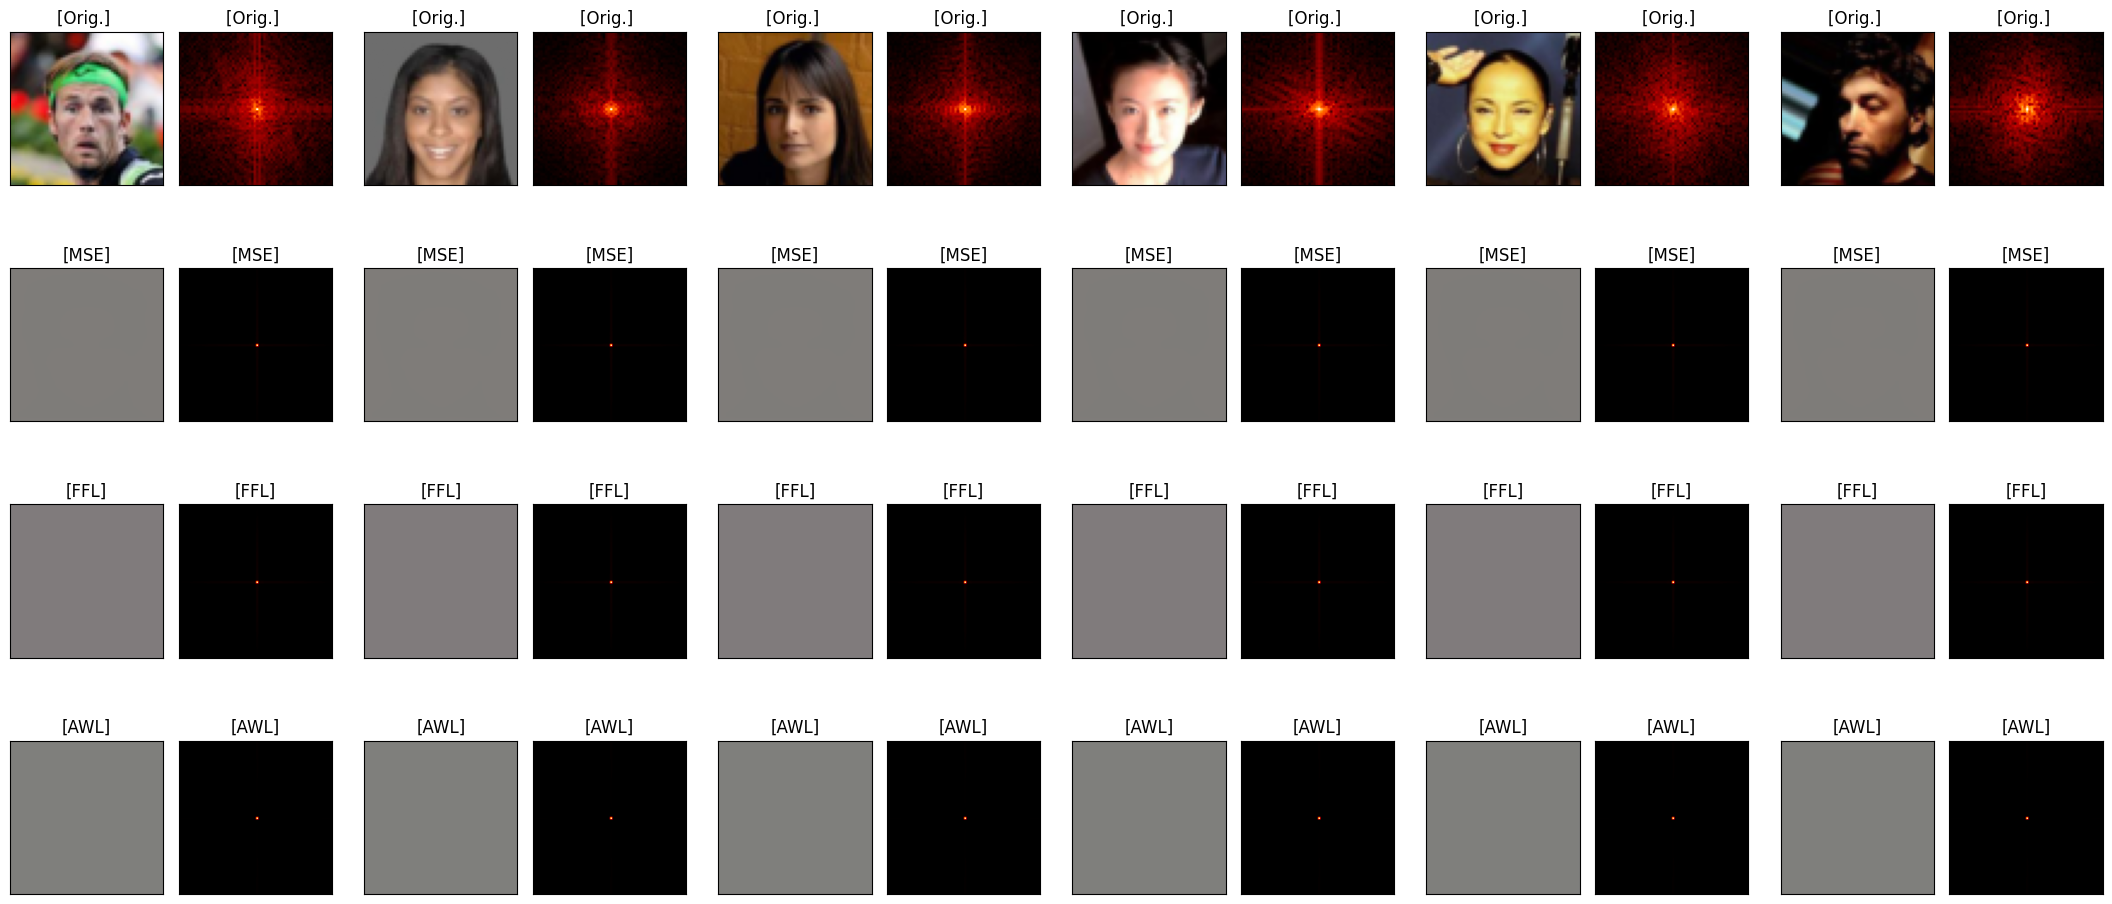

In [ ]:
# Plot the comparisson between the original image and the reconstructed one
plot_comparison(model, valid_loader, n=6)

In [ ]:
def plot(model, data, log, n=(2, 6), idxs=None):
    """Plot the training loss and a comparisson between
    original images and its reconstructions.

    Parameters
    ----------
    model : dict
        Dictionary containing a Convolutional Autoencoder model for each metric

    data : DataLoader
        Training dataset

    log : dict
        Dictionary containing the loss and epochs

    n : tuple(int, int)
        Number of images in row and columns to be plotted. The total number
        of images will be given by the multiplication of the values.

    idxs : list-like, default=None
        List of data indices to be used for visualisation. Default is
        None, which generates random sampling

    Returns
    -------
        List of data indices used for visualisation.

    """
    # Get the batch for comparison
    images, labels = next(iter(data))
    
    # Set up plot
    fig = plt.figure(figsize=(27, 16))
    outer = gridspec.GridSpec(1, 2, wspace=0.05, hspace=0,
                              width_ratios=[0.25, 0.75])

    # Loss plot
    metrics = [key.split("_")[-1] for key in log.keys()
                                if "_" in key and "training" in key]
    intermediate_loss = gridspec.GridSpecFromSubplotSpec(len(metrics), 1,
                            subplot_spec=outer[0], 
                            wspace=0.1, hspace=0.2)

    for i, metric in enumerate(metrics):
        ax = plt.Subplot(fig, intermediate_loss[i])
        ax.plot(log["epochs"], log["training_" + metric], 
                label="Training")
        ax.plot(log["epochs"], log["validation_" + metric], 
                label="Validation")
        ax.grid(alpha=.25)
        if i == len(metrics) - 1:
            ax.set_xlabel("Epochs")
        else:
            ax.get_xaxis().set_visible(False)
        ax.title.set_text(metric + " Loss")
        ax.legend()
        fig.add_subplot(ax)

    # Visualise
    intermediate = gridspec.GridSpecFromSubplotSpec(n[0] * (len(metrics) + 1), n[1],
                        subplot_spec=outer[1], 
                        wspace=0.1, hspace=0.1)
    
    if idxs is None:
        idxs = torch.randint(0, images.shape[0], (n[0] * n[1], ))

    for i, idx in enumerate(idxs):
        # Original image
        inner_real = gridspec.GridSpecFromSubplotSpec(1, 2,
                         subplot_spec=intermediate[i], 
                         wspace=0.05, hspace=0)

        # Spatial Domain
        ax = plt.Subplot(fig, inner_real[0])
        ax.imshow(np.transpose(images[idx].squeeze().numpy(), (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i < n[1]:
            ax.title.set_text("[Orig.] ")
        fig.add_subplot(ax)

        # Frequency Domain
        gray_image = Grayscale()(images[idx])
        fft = torch.fft.fft2(gray_image)
        fftshifted = torch.fft.fftshift(fft)

        ax = plt.Subplot(fig, inner_real[1])
        ax.imshow(np.transpose(torch.log(1 + torch.abs(fftshifted)).numpy(),
                            (1, 2, 0)),
                cmap="gist_heat")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(ax)

        for k, metric in enumerate(model.keys()):
            # Set to evaluation
            model[metric].eval()

            # Recon Model
            inner_recon = gridspec.GridSpecFromSubplotSpec(1, 2,
                            subplot_spec=intermediate[i + (k + 1) * n[0] * n[1]],
                            wspace=0.05, hspace=0)
            
            # Spatial Domain
            recon = model[metric](images[idx].unsqueeze(0).to(device))
            ax = plt.Subplot(fig, inner_recon[0])
            ax.imshow(np.transpose(recon.cpu().detach().squeeze().numpy(), (1, 2, 0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i < n[1]:
                ax.title.set_text("[" + metric + "]")
            fig.add_subplot(ax)

            # Reconstructed Image (Frequency Domain)
            gray_image = Grayscale()(recon)
            fft = torch.fft.fft2(gray_image)
            fftshifted = torch.fft.fftshift(fft)

            ax = plt.Subplot(fig, inner_recon[1])
            ax.imshow(torch.log(1 + torch.abs(fftshifted)).squeeze().cpu().detach().numpy(), 
                      cmap="gist_heat")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            fig.add_subplot(ax)

    plt.show()
    print("\n")
    return idxs

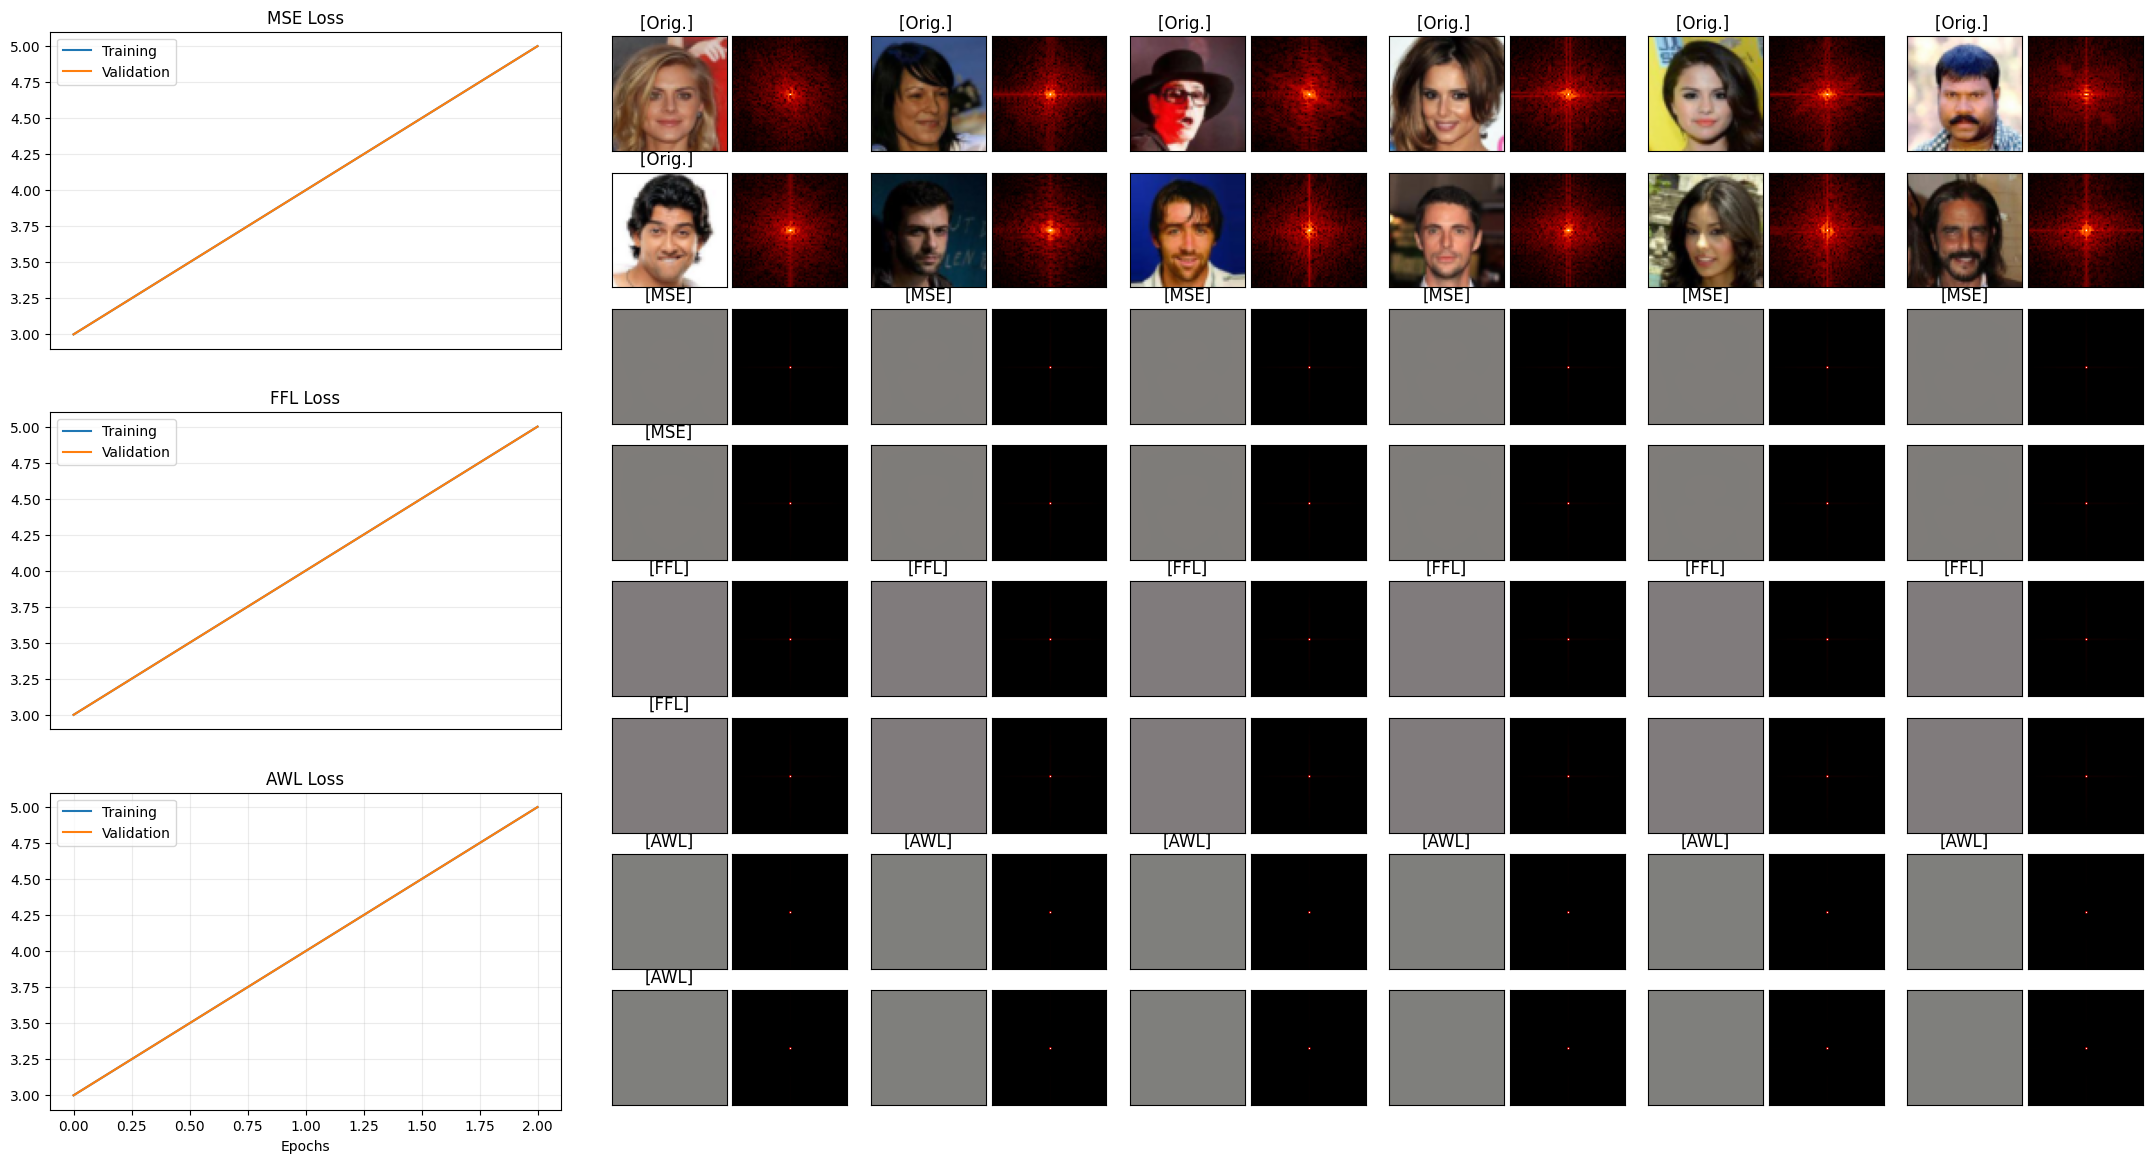

tensor([160, 429, 377, 380, 265, 203,   8, 327, 507, 330, 293, 269])

In [ ]:
log = {"epochs": [0, 1, 2]}
log.update({"training_" + metric: [3, 4, 5] for metric in model.keys()})
log.update({"validation_" + metric: [3, 4, 5] for metric in model.keys()})
plot(model, valid_loader, log)